In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [4]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]
df

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369
...,...,...,...,...,...
9699,140,164.0,2981.107371,2013,15.101802
9700,180,154.0,2439.525729,2004,17.962326
9701,220,138.0,2583.471318,2008,17.186587
9702,230,177.0,2905.527390,2011,15.331551


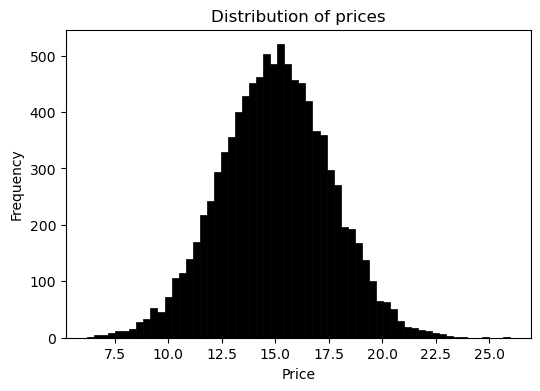

In [5]:
plt.figure(figsize=(6, 4))

sns.histplot(df.fuel_efficiency_mpg, bins=60, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [6]:
#Question 1

df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [7]:
#Question 2
median_hp = df['horsepower'].median()
median_hp

149.0

In [ ]:
# Prepare and split the dataset

np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.fuel_efficiency_mpg.values
y_val_orig = df_val.fuel_efficiency_mpg.values
y_test_orig = df_test.fuel_efficiency_mpg.values

y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [14]:
#Question 3
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

def prepare_X_zero(df):
    df_num = df[base].copy()
    df_num = df_num.fillna(0)
    return df_num.values

def prepare_X_mean(df):
    df_num = df[base].copy()
    df_num['horsepower'] = df_num['horsepower'].fillna(hp_mean)
    return df_num.values

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

X_train_zero = prepare_X_zero(df_train)
X_val_zero = prepare_X_zero(df_val)

w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)
y_pred_val_zero = w0_zero + X_val_zero.dot(w_zero)
rmse_zero = rmse(y_val, y_pred_val_zero)

print("RMSE (fill with 0):", round(rmse_zero, 2))

###

hp_mean = df_train['horsepower'].mean()

X_train_mean = prepare_X_mean(df_train)
X_val_mean = prepare_X_mean(df_val)

w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_val_mean = w0_mean + X_val_mean.dot(w_mean)
rmse_mean = rmse(y_val, y_pred_val_mean)

print("RMSE (fill with mean):", round(rmse_mean, 2))


RMSE (fill with 0): 0.04
RMSE (fill with mean): 0.04


In [12]:
#Question 4


def train_ridge_regression(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T @ X
    # ridge penalty (do not regularize intercept)
    reg = np.eye(XTX.shape[0])
    reg[0, 0] = 0.0
    XTX_reg = XTX + r * reg

    w_full = np.linalg.inv(XTX_reg) @ X.T @ y
    return w_full[0], w_full[1:]

# prepare data (fill NA with 0)
X_train = prepare_X_zero(df_train)
X_val   = prepare_X_zero(df_val)

rs = [0, 0.01, 0.1, 1, 5, 10, 100]
scores = {}
for r in rs:
    w0, w = train_ridge_regression(X_train, y_train, r=r)
    y_pred = w0 + X_val @ w
    scores[r] = round(rmse(y_val, y_pred), 2)

scores


{0: np.float64(0.04),
 0.01: np.float64(0.04),
 0.1: np.float64(0.04),
 1: np.float64(0.04),
 5: np.float64(0.04),
 10: np.float64(0.04),
 100: np.float64(0.04)}

In [13]:
#Question 5

def split_with_seed(df, seed):
    np.random.seed(seed)
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.shuffle(idx)
    d = df.iloc[idx].copy()

    df_train = d.iloc[:n_train].copy()
    df_val   = d.iloc[n_train:n_train+n_val].copy()
    df_test  = d.iloc[n_train+n_val:].copy()

    y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
    y_val   = np.log1p(df_val.fuel_efficiency_mpg.values)

    for part in (df_train, df_val, df_test):
        del part['fuel_efficiency_mpg']

    return df_train, df_val, y_train, y_val

rs = []
for seed in range(10):  # 0..9
    df_train, df_val, y_train, y_val = split_with_seed(df, seed)
    X_train = prepare_X_zero(df_train)
    X_val   = prepare_X_zero(df_val)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    rs.append(rmse(y_val, y_pred))

std = np.std(rs)
round(std, 3)


np.float64(0.001)

In [30]:
#Question 6


# split with seed=9
seed = 9
np.random.seed(seed)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.shuffle(idx)
d = df.iloc[idx].copy()

df_train = d.iloc[:n_train].copy()
df_val   = d.iloc[n_train:n_train+n_val].copy()
df_test  = d.iloc[n_train+n_val:].copy()

# combine train + val
df_full = pd.concat([df_train, df_val], ignore_index=True)

# targets on ORIGINAL SCALE (no log)
y_full = df_full.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

# drop target
for part in (df_full, df_test):
    del part['fuel_efficiency_mpg']

# fill NAs with 0
X_full = prepare_X_zero(df_full)
X_test = prepare_X_zero(df_test)

# ridge with r=0.001 (intercept not regularized)
w0, w = train_ridge_regression(X_full, y_full, r=0.001)

# evaluate on test (original scale)
y_pred_test = w0 + X_test @ w
round(rmse(y_test, y_pred_test), 2)


np.float64(0.52)